## Notebook 10.4

Estimating volatility (variance) of a dataset by fitting data to a series of normal distributions each with a separate mean and variance parameter. This example is an implementation of the model from pymc3 [Case study 2](https://docs.pymc.io/notebooks/getting_started.html#Case-study-1:-Stochastic-volatility). 

In [1]:
# pip install pymc3

In [2]:
# suppress warning messages from pymc3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pymc3 as pm
import numpy as np
import pandas as pd
import toyplot
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

### pymc3 case study I: stochastic volatility

The example from the pymc3 tutorial was examining stock prices for a daily stock over a long time period, where they found there was increased volatility around the time of the financial collapse in 2007. Here we will simulate data to have a similar pattern, with low volatility (data drawn from a normal distribution with low stdev) before and after a period of high volatility. 

The model in the example uses a slightly more complicated model, which I've simplified here, however, as a result our generative model does not exactly match our fitted model. 

In [6]:
# simulate data with different volatilities
np.random.seed(123)
returns = pd.DataFrame({
    "returns": np.concatenate([
        np.random.normal(0, 0.2, 50),
        np.random.normal(0, 0.8, 50),
        np.random.normal(0, 0.3, 50),
        ])})
returns.head()

returns
0 -0.217126
1  0.199469
2  0.056596
3 -0.301259
4 -0.115720

### Fit a model

As described in the tutorial, we will model volatility using the StudenT distribution, which is similar to the Normal distribution but has an additional parameter for the degrees of freedom of the model, where lower df leads to fatter tails of the distribution. This is meant to allow for more uncertainty when sample sizes are low, and thus can better acommodate outlier values. To learn more about this distribution, or any other, search google and wikipedia, and use tab-completion to look at the docs in the pymc3 object.  

In [7]:
nsize = len(returns)

In [8]:
with pm.Model() as sp500_model:
    
    # draw steps from a halfnormal distribution
    nu = pm.Exponential('nu', 1./10)
    sigma = pm.HalfNormal('sigma', sd=1)

    # random walk: s draws nsize random values for next step in walk
    s = pm.GaussianRandomWalk(
        's', 
        sigma**-2, 
        shape=nsize)
    
    # deterministic = volatility is completely explained by s
    volatility = pm.Deterministic('volatility', pm.math.exp(-2*s))

    # expected distribution is StudentT with 
    # volaitility as scale factor describing precision of normally dist moves
    # nu as degrees of freedom 
    r = pm.StudentT('r', nu, lam=1./volatility, observed=returns.returns)

In [9]:
with sp500_model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [02:31<00:00, 69.37it/s]


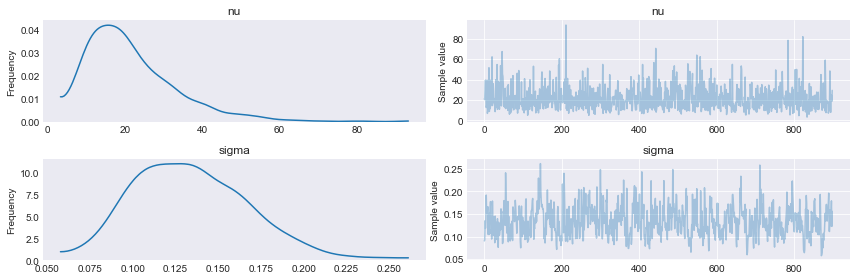

In [10]:
pm.traceplot(trace[1000::10], [nu, sigma]);

In [11]:
# plot inferred volatility along with the data
canvas = toyplot.Canvas(width=500, height=325)
axes = canvas.cartesian(ylabel="volatility", xlabel="time")
axes.plot(returns);
axes.plot(
    1 / np.exp(trace['s', 1000::10].T),
    color='red',
    opacity=0.01);
#canvas.autorender(autoformat='png')

<path d="M 50.0 194.77067542970505 L 52.666666666666664 176.02389098074769 L 55.333333333333336 182.45319351753207 L 58.0 198.55665242526283 L 60.666666666666671 190.20740226771682 L 63.333333333333336 170.13707116612565 L 66.0 206.84011319053764 L 68.666666666666671 188.86021365970561 L 71.333333333333343 173.60657367165021 L 74.0 192.80066362038588 L 76.666666666666657 191.10997536459848 L 79.333333333333329 185.85238072043202 L 82.0 171.57749336488141 L 84.666666666666657 190.75011797016185 L 87.333333333333329 188.9958376368146 L 90.0 188.90916148056669 L 92.666666666666657 165.14662925547091 L 95.333333333333343 165.31892519923593 L 98.0 175.9635149190901 L 100.66666666666667 181.5243224074263 L 103.33333333333334 178.36368281693382 L 106.0 171.58341174664281 L 108.66666666666666 193.42250481562149 L 111.33333333333334 174.41753859696107 L 114.0 196.2849260097411 L 116.66666666666667 190.73976352208066 L 119.33333333333334 176.83605323779727 L 122.0 197.85812630203372 L 124.66666666666666 186.26061848169797 L 127.33333333333333 192.75579406273718 L 130.0 187.30057433477538 L 132.66666666666666 210.18730194914653 L 135.33333333333331 200.94379794058864 L 138.0 191.29889511138126 L 140.66666666666666 176.65283811417277 L 143.33333333333331 186.56272114511194 L 146.0 184.97438675692868 L 148.66666666666666 178.80599560007943 L 151.33333333333334 192.91582708708145 L 154.0 182.44735408573436 L 156.66666666666669 192.24829866259057 L 159.33333333333331 200.54902544708546 L 162.0 188.5180981437959 L 164.66666666666669 179.83574723835449 L 167.33333333333334 181.95269854100178 L 170.0 185.10647445030938 L 172.66666666666669 163.46871260656044 L 175.33333333333334 181.28379055722098 L 178.0 176.19137594656391 L 180.66666666666666 164.85670995351842 L 183.33333333333334 231.58707163380495 L 186.0 222.39637556737833 L 188.66666666666666 122.22635989557449 L 191.33333333333334 213.73025846867824 L 194.0 183.93140370908014 L 196.66666666666666 146.50462510072344 L 199.33333333333334 152.93456991344587 L 202.0 121.82409744868005 L 204.66666666666666 131.15681106679511 L 207.33333333333334 146.50186389059348 L 210.0 212.81751371289889 L 212.66666666666666 156.38494395944417 L 215.33333333333334 173.68620819775279 L 218.0 232.74555655785642 L 220.66666666666666 133.9772343268333 L 223.33333333333334 155.93948475517163 L 226.0 183.36235709728049 L 228.66666666666666 193.39131419543889 L 231.33333333333334 228.13884120922833 L 234.0 177.81713335188923 L 236.66666666666666 168.13619169995681 L 239.33333333333334 214.92157943275802 L 242.0 143.16065423241693 L 244.66666666666666 224.49930967338921 L 247.33333333333331 261.43161260152789 L 250.0 147.56982472786279 L 252.66666666666669 199.52117737167589 L 255.33333333333334 189.53706507126856 L 258.0 215.15060202170193 L 260.66666666666663 242.8146593858265 L 263.33333333333331 139.81145450992813 L 266.0 209.79928341848918 L 268.66666666666663 125.20571042667417 L 271.33333333333331 155.93690529641376 L 274.0 196.33129328182858 L 276.66666666666669 224.0924864405672 L 279.33333333333331 211.36863152193644 L 282.0 228.65083271942609 L 284.66666666666669 109.86391905482533 L 287.33333333333331 179.08011571172631 L 290.0 143.59260046832125 L 292.66666666666669 230.6246737643682 L 295.33333333333331 178.48273533450785 L 298.0 142.59697020289119 L 300.66666666666669 197.06038742958856 L 303.33333333333331 147.87987947881726 L 306.0 224.0444448322076 L 308.66666666666669 234.08497560626904 L 311.33333333333331 171.3415779651871 L 314.0 198.6503516446119 L 316.66666666666669 176.33226169483029 L 319.33333333333331 211.70148707552605 L 322.0 175.38442742114799 L 324.66666666666669 149.92289698186426 L 327.33333333333331 185.33245074932498 L 330.0 184.53908125971711 L 332.66666666666669 182.57608195737785 L 335.33333333333331 210.13667209568914 L 338.0 179.24702036418083 L 340.66666666666669 206.67303154421549 L 343.33333333333331 190.77367457467139 L 346.0 168.22126108034956 L 348.66666666666669 194